In [ ]:
import os
import shutil
import os
 
# get current directory
cwd = os.getcwd()
parent = os.path.dirname(cwd)
parent = os.path.dirname(parent)

src_folder = parent + '\\Generation\\runs\\' 
dst_folder = './src/'
print(src_folder)
print(dst_folder)

# Copy all files from src_folder to dst_folder
for file_name in os.listdir(src_folder):
    shutil.copy(src_folder + file_name, dst_folder)

In [ ]:
exp_name = 'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java'
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
!python convert_to_pre_eval.py --source_file $sf --target_dir $td


In [ ]:
# import subprocess
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
eval_cmd = f"podman run --rm --network none -v ./{td}:/{td}:rw multipl-e-eval --dir /{td} --output-dir /{td} --recursive"


# # subprocess.run(eval_cmd, shell=True)
print("### EVALUATION COMMAND ###")
print('#',eval_cmd)
print("### EVALUATION COMMAND ###")


In [ ]:
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py:/tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py:rw multipl-e-eval --dir /tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py --output-dir /tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py --recursive
### EVALUATION COMMAND ###

In [ ]:
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
target_dir = f'{td}'
output_file = f'res/{exp_name}_results.json'
!python pass_k.py $target_dir --output $output_file

#### Visualize the results

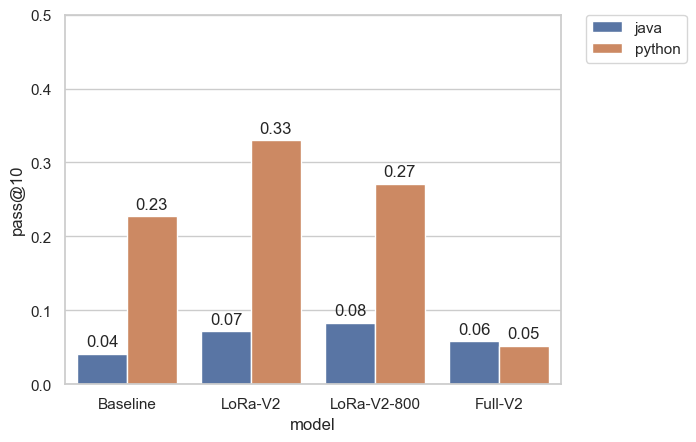

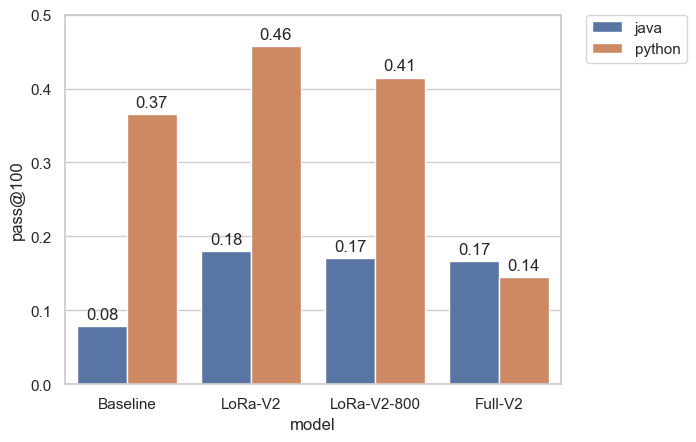

In [7]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


#get all the results files in the res folder
results_files = [f for f in os.listdir('res') if os.path.isfile(os.path.join('res', f))]

#load all the results files into a dictionary
results = {}
for f in results_files:
    with open(os.path.join('res', f)) as json_file:
        results[f] = json.load(json_file)

#Models Short Names
model_names_dict = {
    'codegen_350M_mono_humaneval_py': 'Baseline',
    'codegen_350M_mono_humaneval_java': 'Baseline',

    'codegen_350M_mono_the_stack_dedup_java_train_peft_humaneval_py': 'LoRa-V1',
    'codegen_350M_mono_the_stack_dedup_java_train_peft_humaneval_java': 'LoRa-V1',
    
    'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py': 'Full-V2',
    'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_java': 'Full-V2',
    
    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py': 'LoRa-V2',
    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java': 'LoRa-V2',

    
    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py': 'LoRa-V2-800',
    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java': 'LoRa-V2-800',

}


#Merge all the results into a single dataframe
dict_df = {
    'model': [],
    'dataset': [],
    'pass@10': [],
    'pass@100': [],
    'num_problems': [],
    'min_completions': [],
    'max_completions': [],
    'programming_language': []
}

for model in results.keys():
    model_results = results[model]
    model_name = model.split('_results.json')[0]
    if model_name in model_names_dict.keys():
        model_name = model_names_dict[model_name]
    dataset_name = model_results['pass@10']['dataset']
    pass_10 = model_results['pass@10']['estimate']
    pass_100 = model_results['pass@100']['estimate']
    num_problems = model_results['pass@10']['num_problems']
    min_completions = model_results['pass@10']['min_completions']
    max_completions = model_results['pass@10']['max_completions']
    if 'humaneval_py' in dataset_name:
        programming_language = 'python'
    elif 'humaneval_java' in dataset_name:
        programming_language = 'java'
    else:
        programming_language = 'unknown'
    dict_df['model'].append(model_name)
    dict_df['dataset'].append(dataset_name)
    dict_df['pass@10'].append(pass_10)
    dict_df['pass@100'].append(pass_100)
    dict_df['num_problems'].append(num_problems)
    dict_df['min_completions'].append(min_completions)
    dict_df['max_completions'].append(max_completions)
    dict_df['programming_language'].append(programming_language)

df = pd.DataFrame(dict_df)

#Drop the dataset column
df = df.drop(columns=['dataset'])

#Drop the min_completions and max_completions columns
df = df.drop(columns=['min_completions', 'max_completions'])

#Drop the num_problems column
df = df.drop(columns=['num_problems'])

#Plot the results
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="model", y="pass@10", hue="programming_language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 0.5
plt.ylim(0, 0.5)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#plot the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#Plot the results
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="model", y="pass@100", hue="programming_language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 0.5
plt.ylim(0, 0.5)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#plot the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



### ALL FLOW

In [3]:
import os
import shutil
import subprocess

 
# get current directory
cwd = os.getcwd()
parent = os.path.dirname(cwd)
parent = os.path.dirname(parent)

src_folder = parent + '\\Generation\\runs\\' 
dst_folder = './src/'

# Copy all files from src_folder to dst_folder
for file_name in os.listdir(src_folder):
    shutil.copy(src_folder + file_name, dst_folder)


#Loop over all the files in the src folder and get the experiment names to run
for file_name in os.listdir(src_folder):
    exp_name = file_name.split('.jsonl')[0]
    #Print the experiment name
    print(f'Now running experiment: {exp_name}')

    #Convert the jsonl file to the pre-evaluation format
    sf = f'src/{exp_name}.jsonl'
    td = f'tgt/{exp_name.replace("-", "")}'
    print(f'Converting {sf} to {td}')
    !python convert_to_pre_eval.py --source_file $sf --target_dir $td
    print('Done!')

    #Run the evaluation
    print(f'Running evaluation on {td}')
    eval_cmd = f"podman run --rm --network none -v ./{td}:/{td}:rw multipl-e-eval --dir /{td} --output-dir /{td} --recursive"
    subprocess.run(eval_cmd, shell=True)
    print('Done!')

    #Run the pass@k
    print(f'Running pass@k on {td}')
    target_dir = f'{td}'
    output_file = f'res/{exp_name}_results.json'
    !python pass_k.py $target_dir --output $output_file
    print('Done!')

    

Now running experiment: codegen_350M_mono_humaneval_java
Converting src/codegen_350M_mono_humaneval_java.jsonl to tgt/codegen_350M_mono_humaneval_java
Done.
Done!
Running evaluation on tgt/codegen_350M_mono_humaneval_java



100%|██████████| 21000/21000 [00:00<00:00, 874854.83jsonline/s]


Done!
Running pass@k on tgt/codegen_350M_mono_humaneval_java
Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
Reading results from tgt/codegen_350M_mono_humaneval_java...
And saving results to res/codegen_350M_mono_humaneval_java_results.json...
For file tgt\codegen_350M_mono_humaneval_java\HumanEval_23_strlen.results.json n = 200 and c = 28
For file tgt\codegen_350M_mono_humaneval_java\HumanEval_24_largest_divisor.results.json n = 200 and c = 1
For file tgt\codegen_350M_mono_humaneval_java\HumanEval_28_concatenate.results.json n = 200 and c = 3
For file tgt\codegen_350M_mono_humaneval_java\HumanEval_31_is_prime.results.json n = 200 and c = 14
For file tgt\codegen_350M_mono_humaneval_java\HumanEval_35_max_element.results.json n = 200 and c = 1
For file tgt\codegen_350M_mono_humaneval_java\HumanEval_41_car_race_collision.results.json n = 200 and c = 3
For file tgt\codegen_350M_mono_humaneval_java\HumanEval_42_incr_list.results.json n = 200 and c = 1
For file tgt\codegen


100%|██████████| 32200/32200 [00:00<00:00, 769469.91jsonline/s]


Done.Done!
Running evaluation on tgt/codegen_350M_mono_humaneval_py

Done!
Running pass@k on tgt/codegen_350M_mono_humaneval_py
Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
Reading results from tgt/codegen_350M_mono_humaneval_py...
And saving results to res/codegen_350M_mono_humaneval_py_results.json...
For file tgt\codegen_350M_mono_humaneval_py\HumanEval_0_has_close_elements.results.json n = 200 and c = 28
For file tgt\codegen_350M_mono_humaneval_py\HumanEval_101_words_string.results.json n = 200 and c = 4
For file tgt\codegen_350M_mono_humaneval_py\HumanEval_102_choose_num.results.json n = 200 and c = 3
For file tgt\codegen_350M_mono_humaneval_py\HumanEval_116_sort_array.results.json n = 200 and c = 5
For file tgt\codegen_350M_mono_humaneval_py\HumanEval_11_string_xor.results.json n = 200 and c = 47
For file tgt\codegen_350M_mono_humaneval_py\HumanEval_122_add_elements.results.json n = 200 and c = 1
For file tgt\codegen_350M_mono_humaneval_py\HumanEval_12_longes


100%|██████████| 6200/6200 [00:00<00:00, 821529.18jsonline/s]


Done.
Done!
Running evaluation on tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java
Done!
Running pass@k on tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java
Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
Reading results from tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java...
And saving results to res/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java_results.json...
For file tgt\codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java\HumanEval_23_strlen.results.json n = 200 and c = 20
For file tgt\codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java\HumanEval_31_is_prime.results.json n = 200 and c = 5
For file tgt\codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java\HumanEval_35_max_element.results.json n = 200 and c = 3
For file tgt\codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java\HumanEval_41_car_


100%|██████████| 8200/8200 [00:00<00:00, 745007.97jsonline/s]


Done.
Done!
Running evaluation on tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py
Done!
Running pass@k on tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py
Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
Reading results from tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py...
And saving results to res/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py_results.json...
For file tgt\codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py\HumanEval_102_choose_num.results.json n = 200 and c = 1
For file tgt\codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py\HumanEval_112_reverse_delete.results.json n = 200 and c = 1
For file tgt\codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py\HumanEval_11_string_xor.results.json n = 200 and c = 20
For file tgt\codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py\HumanEval_135_can_arra


100%|██████████| 12000/12000 [00:00<00:00, 851577.69jsonline/s]


Done!
Running pass@k on tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java
Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
Reading results from tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java...
And saving results to res/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java_results.json...
Read 58 results
Sample result: {'pass@1': 0.0, 'pass@10': 0.0, 'pass@100': 0.0, 'n': 200, 'temperature': 0.8}
codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java,10,0.08322286145810738,58,33,200
codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java,100,0.17033081407404155,58,33,200
{'pass@10': {'dataset': 'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java',
             'estimate': 0.08322286145810738,
             'max_completions': 200,
             'min_completions': 33,
             'num_problems': 58,
             'pass@k': 10},
 'pass@100': {'dataset': '


100%|██████████| 13200/13200 [00:00<00:00, 395867.30jsonline/s]


Done!
Running pass@k on tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py
Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
Reading results from tgt/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py...
And saving results to res/codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py_results.json...
Read 66 results
Sample result: {'pass@1': 0.0, 'pass@10': 0.0, 'pass@100': 0.0, 'n': 200, 'temperature': 0.8}
codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py,10,0.27113904838848135,66,200,200
codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py,100,0.4146199277246098,66,200,200
{'pass@10': {'dataset': 'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py',
             'estimate': 0.27113904838848135,
             'max_completions': 200,
             'min_completions': 200,
             'num_problems': 66,
             'pass@k': 10},
 'pass@100': {'dataset': 'codegne_fi


100%|██████████| 16000/16000 [00:00<00:00, 528945.20jsonline/s]


Done!
Running pass@k on tgt/codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_java
Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
Reading results from tgt/codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_java...
And saving results to res/codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_java_results.json...
Read 57 results
Sample result: {'pass@1': 0.0, 'pass@10': 0.0, 'pass@100': 0.0, 'n': 200, 'temperature': 0.8}
codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_java,10,0.05826112036542715,57,58,200
codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_java,100,0.16663659536958308,57,58,200
{'pass@10': {'dataset': 'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_java',
             'estimate': 0.05826112036542715,
             'max_completions': 200,
             'min_completions': 58,
             'num_problems': 57,
             'pass@k': 10},
 'pass@100': {'dataset': 'codegne_finetuned_the_stack_ja


100%|██████████| 17200/17200 [00:00<00:00, 356789.03jsonline/s]


Done.
Done!
Running evaluation on tgt/codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py
Done!
Running pass@k on tgt/codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py
Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
Reading results from tgt/codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py...
And saving results to res/codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py_results.json...
Read 86 results
Sample result: {'pass@1': 0.0, 'pass@10': 0.0, 'pass@100': 0.0, 'n': 200, 'temperature': 0.8}
codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py,10,0.05216675674456617,86,200,200
codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py,100,0.1448561913283779,86,200,200
{'pass@10': {'dataset': 'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py',
             'estimate': 0.05216675674456617,
             'max_completions': 200,
             'min_completions': 200,
             'num_problem